## Imports

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import torch

import os
import sys

sys.path.append(os.path.abspath('..'))

torch.cuda.empty_cache()

from src.models.TurbulenceNetwork import TurbulenceNetworkBayesian
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *

from src.models.GaussianProcess import GaussianProcessRegressor, RBFKernel

#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'

%load_ext autoreload
%autoreload 2

%matplotlib inline

## Creating Data

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


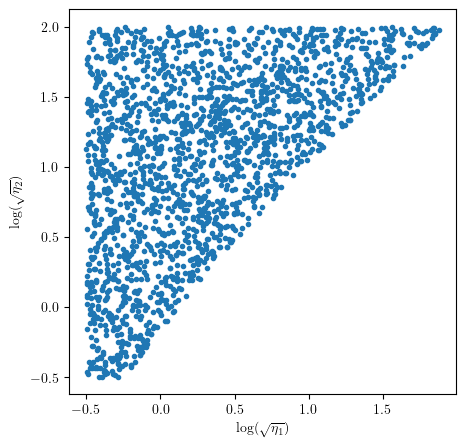

In [5]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.1, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 4_000, shuffle=True, gen_type="d_condition", d_condition=">=")

etas_test, gs_test = generate_log_data(SSG_gen, log, 600, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)

## Defining Data Sets and Scaling

In [6]:
from sklearn.preprocessing import StandardScaler

x_scaler = CustomScalerX().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_train = torch.tensor(x_scaler.transform(etas_train), device=DEVICE)
y_train = torch.tensor(y_scaler.transform(gs_train), device=DEVICE)

x_test = torch.tensor(x_scaler.transform(etas_test), device=DEVICE)
y_test = torch.tensor(y_scaler.transform(gs_test), device=DEVICE)

## Training

In [7]:
trained_gps = []

load = True

if load:
    params = []
    for i in range(3):
        dict = pickle.load(open(f"../data/GP/GP_chpc_GT_0/D_GT_0_{i}_KernelParams.pkl", "rb"))


for i in range(y_train.shape[1]):
    if load:
        kernel = RBFKernel(length_scale=dict['length_scale'], amplitude=dict['amplitude'], device=DEVICE).to(DEVICE)
    else:
        kernel = RBFKernel(length_scale=1.0, amplitude=1.0, device=DEVICE).to(DEVICE)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts=0, max_iter= 0 if load else 2000, batch_size=1000, device=DEVICE)

    gp = gp.fit(x_train, y_train[:, i].unsqueeze(1))
    trained_gps.append(gp)

for gp in trained_gps:
    print(gp.kernel.length_scale, gp.kernel.amplitude)


#kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-6, 1e2))
#gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
#gp = gp.fit(x_train, y_train)

Parameter containing:
tensor(10.7477, requires_grad=True) Parameter containing:
tensor(2.0753, requires_grad=True)
Parameter containing:
tensor(10.7477, requires_grad=True) Parameter containing:
tensor(2.0753, requires_grad=True)
Parameter containing:
tensor(10.7477, requires_grad=True) Parameter containing:
tensor(2.0753, requires_grad=True)


## Plotting Samples

0.022844600415070776


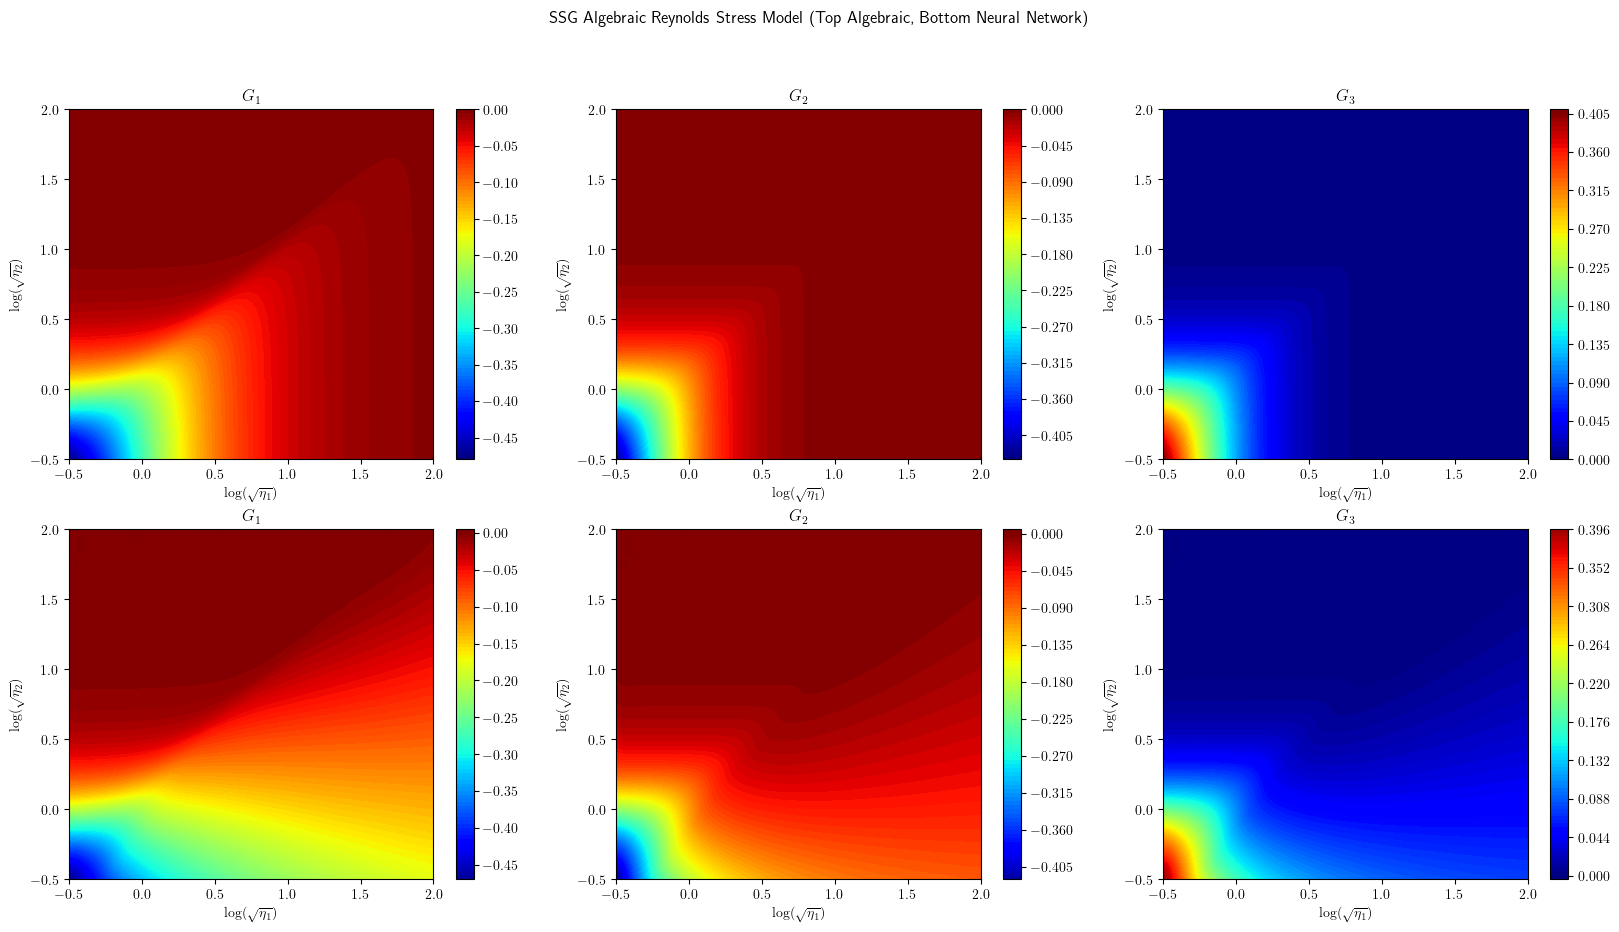

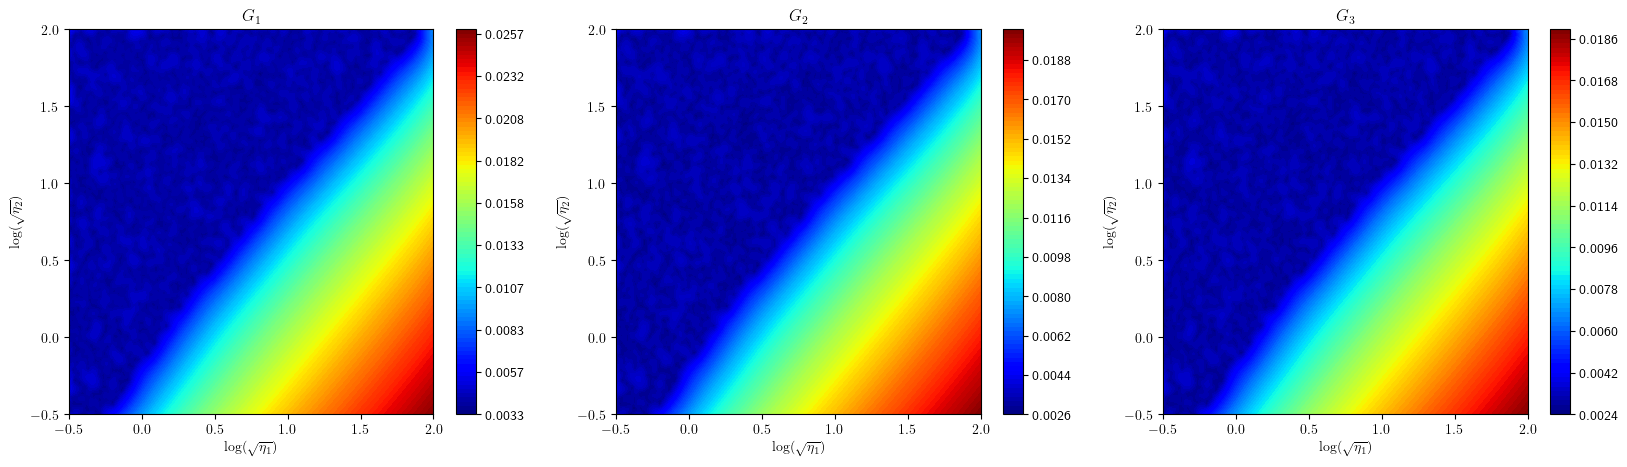

In [8]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s

etas = x_scaler.transform(etas)
etas = torch.tensor(etas, device=DEVICE)

pred_mean = []
pred_std = []

num_splits = 50

for x_split in np.array_split(etas, num_splits):
    pred_mean_split = np.zeros((x_split.shape[0], len(trained_gps)))
    pred_std_split = np.zeros((x_split.shape[0], len(trained_gps)))

    for i, gp in enumerate(trained_gps):
        pred, std = gp.predict(x_split, return_std=True)
        pred_mean_split[:, i], pred_std_split[:, i] = (pred.cpu().detach().squeeze().numpy(), std.cpu().detach().squeeze().numpy())
    
    pred_mean.append(pred_mean_split)
    pred_std.append(pred_std_split)

pred_mean = np.concatenate(pred_mean, axis=0)
pred_std = np.concatenate(pred_std, axis=0)


# y = ln(-G_1)
# E[G_1] = E[-e^y] -e^E[y]

#pred_mean, pred_std = gp.predict(etas, return_std=True)

pred_mean = y_scaler.inverse_transform(pred_mean)
pred_std = pred_std * y_scaler.scale_

print(np.mean(np.abs(target - pred_mean)))

plot_heat_map_compare(x_grid, y_grid, target.T.reshape(3, dim, dim), pred_mean.T.reshape(3, dim, dim))

plot_heat_map_3D(x_grid, y_grid, pred_std.T.reshape(3, dim, dim))

## Output CHPC Result

### Getting test outputs for each sample

0.04327107573440819


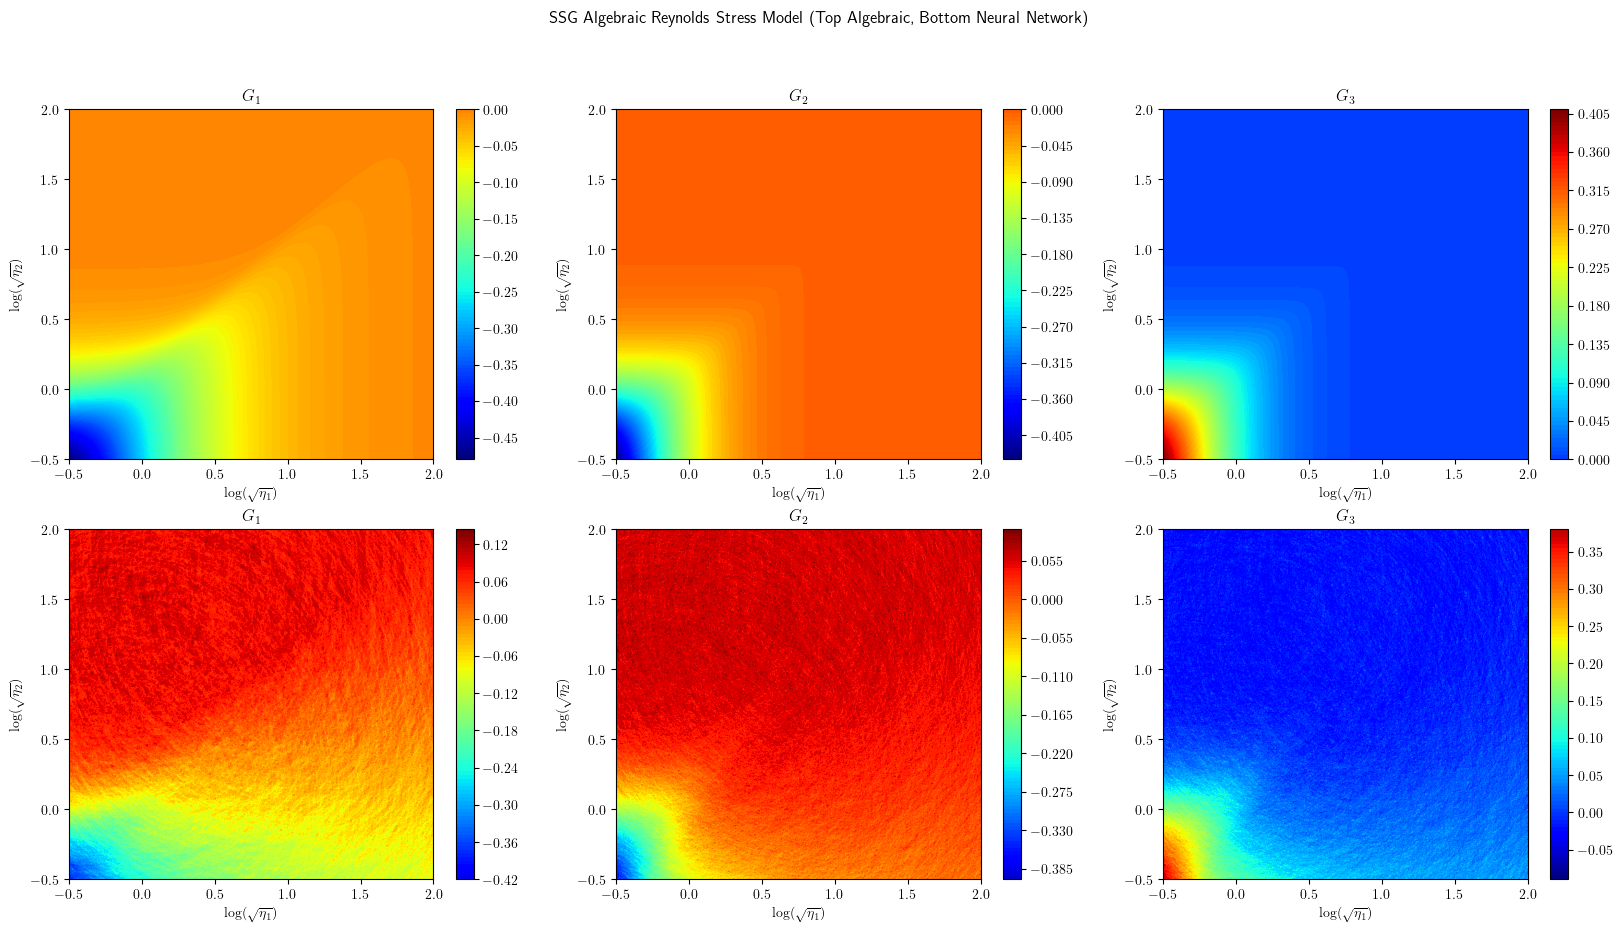

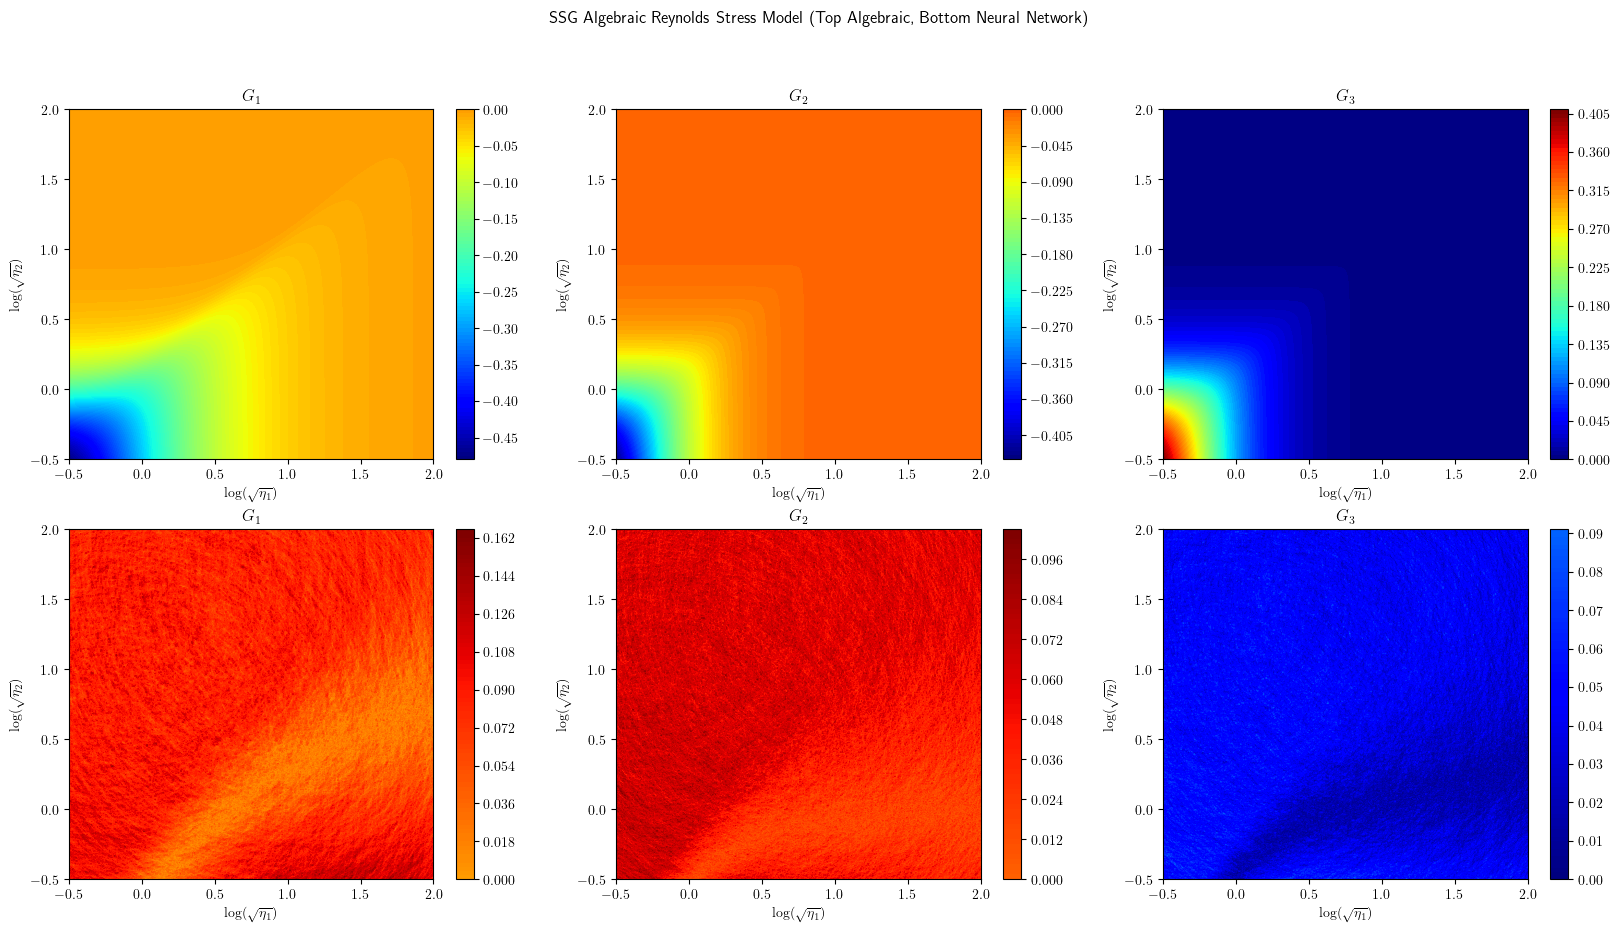

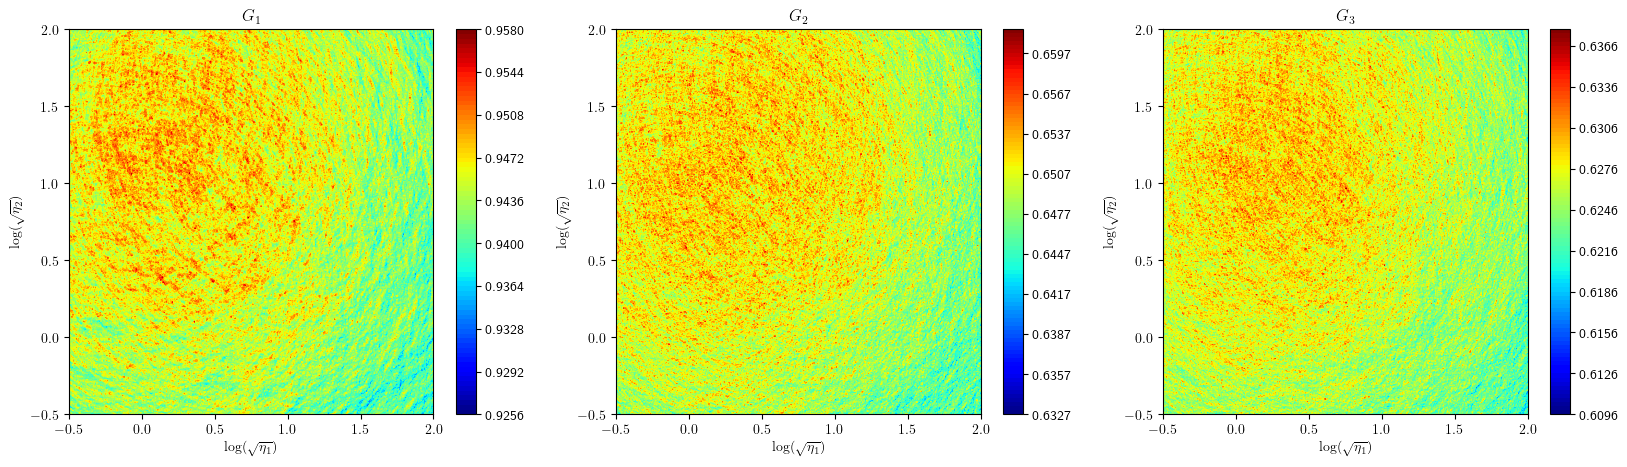

In [4]:
data_dir = "../data/GP/GP_chpc_GT_0/"
save_prefix = "D_GT_0_"

#data_dir = "../data/GP/"
#save_prefix = "GP_"

preds = []
stds = []

for i in range(3):
    pred = np.load(data_dir + save_prefix + f"Mean{i}.npy")
    std = np.load(data_dir + save_prefix + f"Std{i}.npy").reshape(-1, 1)
    preds.append(pred)
    stds.append(std)

preds = np.concatenate(preds, axis=1)
stds = np.concatenate(stds, axis=1)

dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)

print(np.mean(np.abs(G_s - preds)))

plot_heat_map_compare(x_grid, y_grid, G_s.T.reshape(3, dim, dim), preds.T.reshape(3, dim, dim))

plot_heat_map_compare(x_grid, y_grid, G_s.T.reshape(3, dim, dim), np.abs(preds.T.reshape(3, dim, dim) - G_s.T.reshape(3, dim, dim)))


plot_heat_map_3D(x_grid, y_grid, stds.T.reshape(3, dim, dim))